In [2]:
import random
import sys,os,os.path
import numpy as np
import re
import operator
import itertools
import math
import random
import torch
from collections import deque
import copy
import matplotlib.pyplot as plt
import networkx as nx

seed = 0
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt
from ComputationalGraphPrimer import *

class ModifiedPrimer(ComputationalGraphPrimer):

    def __init__(self, *args, **kwargs ):
        rate_mu = rate_beta1 = rate_beta2 = None
        if 'rate_mu' in kwargs:   rate_mu = kwargs.pop('rate_mu')
        if 'rate_beta1' in kwargs:  rate_beta1 = kwargs.pop('rate_beta1')
        if 'rate_beta2' in kwargs:  rate_beta2 = kwargs.pop('rate_beta2')
        if 'rate_ep' in kwargs:   rate_ep = kwargs.pop('rate_ep')
        if rate_mu:
            self.rate_mu = rate_mu
        else:
            self.rate_mu = 0.9
        if rate_beta1:
            self.rate_beta1 = rate_beta1
        else:
            self.rate_beta1 = 0.9
        if rate_beta2:
            self.rate_beta2 = rate_beta2
        else:
            self.rate_beta2 = 0.99
        self.epsilon = 1e-8
        self.loss_running_record = []
        super().__init__(*args, **kwargs )

    def run_training_loop_one_neuron_model(self, training_data, *, algo="SGD", show_process=False):
        """
        The training loop must first initialize the learnable parameters.  Remember, these are the 
        symbolic names in your input expressions for the neural layer that do not begin with the 
        letter 'x'.  In this case, we are initializing with random numbers from a uniform distribution 
        over the interval (0,1).
        """
        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}

        self.bias = random.uniform(0,1)                   ## Adding the bias improves class discrimination.
                                                          ##   We initialize it to a random number.

        class DataLoader:
            """
            To understand the logic of the dataloader, it would help if you first understand how 
            the training dataset is created.  Search for the following function in this file:

                             gen_training_data(self)
           
            As you will see in the implementation code for this method, the training dataset
            consists of a Python dict with two keys, 0 and 1, the former points to a list of 
            all Class 0 samples and the latter to a list of all Class 1 samples.  In each list,
            the data samples are drawn from a multi-dimensional Gaussian distribution.  The two
            classes have different means and variances.  The dimensionality of each data sample
            is set by the number of nodes in the input layer of the neural network.

            The data loader's job is to construct a batch of samples drawn randomly from the two
            lists mentioned above.  And it mush also associate the class label with each sample
            separately.
            """
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]   ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]   ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data
                batch = [batch_data, batch_labels]
                return batch                

        # list of available optimizer
        algos = {
            "SGD":  self.backprop_and_update_params_one_neuron_model,
            "SGD+": self.backprop_and_update_params_one_neuron_model_momentum,
            "Adam": self.backprop_and_update_params_one_neuron_model_adam,
        }

        backprop = None
        if algo in algos: 
            backprop = algos[algo]
        else:
            raise ValueError("algorithm does not exist\n")

        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                    ##  Average the loss over iterations for printing out 
                                                                           ##    every N iterations during the training loop.
        for i in range(self.training_iterations):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            y_preds, deriv_sigmoids =  self.forward_prop_one_neuron_model(data_tuples)              ##  FORWARD PROP of data
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ##  Find loss
            loss_avg = loss / float(len(class_labels))                                              ##  Average the loss over batch
            avg_loss_over_iterations += loss_avg                          
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                # print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))                 ## Display average loss
                avg_loss_over_iterations = 0.0                                                     ## Re-initialize avg loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            deriv_sigmoid_avg = sum(deriv_sigmoids) / float(len(class_labels))
            data_tuple_avg = [sum(x) for x in zip(*data_tuples)]
            data_tuple_avg = list(map(operator.truediv, data_tuple_avg, 
                                     [float(len(class_labels))] * len(class_labels) ))
            backprop(y_error_avg, data_tuple_avg, deriv_sigmoid_avg)     ## BACKPROP loss
        self.loss_running_record = loss_running_record  ## add this for convenience
        if show_process:
            plt.figure()     
            plt.plot(loss_running_record)
            plt.show()  

    def run_training_loop_multi_neuron_model(self, training_data, algo="SGD", show_process=False):

        class DataLoader:
            """
            To understand the logic of the dataloader, it would help if you first understand how 
            the training dataset is created.  Search for the following function in this file:

                             gen_training_data(self)
           
            As you will see in the implementation code for this method, the training dataset
            consists of a Python dict with two keys, 0 and 1, the former points to a list of 
            all Class 0 samples and the latter to a list of all Class 1 samples.  In each list,
            the data samples are drawn from a multi-dimensional Gaussian distribution.  The two
            classes have different means and variances.  The dimensionality of each data sample
            is set by the number of nodes in the input layer of the neural network.

            The data loader's job is to construct a batch of samples drawn randomly from the two
            lists mentioned above.  And it mush also associate the class label with each sample
            separately.
            """
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]    ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]    ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data       
                batch = [batch_data, batch_labels]
                return batch                


        """
        The training loop must first initialize the learnable parameters.  Remember, these are the 
        symbolic names in your input expressions for the neural layer that do not begin with the 
        letter 'x'.  In this case, we are initializing with random numbers from a uniform distribution 
        over the interval (0,1).
        """
        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}

        self.bias = [random.uniform(0,1) for _ in range(self.num_layers-1)]      ## Adding the bias to each layer improves 
                                                                                 ##   class discrimination. We initialize it 
                                                                                 ##   to a random number.

        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                          ##  Average the loss over iterations for printing out 
                                                                                 ##    every N iterations during the training loop.   
        # list of available optimizer
        algos = {
            "SGD":  self.backprop_and_update_params_multi_neuron_model,
            "SGD+": self.backprop_and_update_params_multi_neuron_model_momentum,
            "Adam": self.backprop_and_update_params_multi_neuron_model_adam,
        }

        backprop = None
        if algo in algos: 
            backprop = algos[algo]
        else:
            raise ValueError("algorithm does not exist\n")
        for i in range(self.training_iterations):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            self.forward_prop_multi_neuron_model(data_tuples)                                  ## FORW PROP works by side-effect 
            predicted_labels_for_batch = self.forw_prop_vals_at_layers[self.num_layers-1]      ## Predictions from FORW PROP
            y_preds =  [item for sublist in  predicted_labels_for_batch  for item in sublist]  ## Get numeric vals for predictions
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ## Calculate loss for batch
            loss_avg = loss / float(len(class_labels))                                         ## Average the loss over batch
            avg_loss_over_iterations += loss_avg                                              ## Add to Average loss over iterations
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))            ## Display avg loss
                avg_loss_over_iterations = 0.0                                                ## Re-initialize avg-over-iterations loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            backprop(y_error_avg, class_labels)      ## BACKPROP loss
        self.loss_running_record = loss_running_record  ## add this for convenience
        if show_process:
            plt.figure()     
            plt.plot(loss_running_record)
            plt.show()  

    def backprop_and_update_params_one_neuron_model_momentum(self, y_error, vals_for_input_vars, deriv_sigmoid,\
        *, \
        vals_momentum={}):

        input_vars = self.independent_vars
        input_vars_to_param_map = self.var_to_var_param[self.output_vars[0]]
        param_to_vars_map = {param : var for var, param in input_vars_to_param_map.items()}
        vals_for_input_vars_dict =  dict(zip(input_vars, list(vals_for_input_vars)))
        vals_for_learnable_params = self.vals_for_learnable_params

        if vals_momentum == {}:
            ## for the first back-propagation we initialize the momentum as the first gradient,
            ## this way we can avoid the bias of momentum to zero.
            for i,param in enumerate(self.vals_for_learnable_params):
                ## Calculate the next step in the parameter hyperplane
                step = self.learning_rate * y_error * vals_for_input_vars_dict[param_to_vars_map[param]] * deriv_sigmoid    
                vals_momentum[param] = step
                ## Update the learnable parameters
                self.vals_for_learnable_params[param] += step
            # self.bias += self.learning_rate * y_error * deriv_sigmoid    ## Update the bias
            bias = self.learning_rate * y_error * deriv_sigmoid
            vals_momentum["_b"] = bias
            self.bias += bias
        else:
            for i,param in enumerate(self.vals_for_learnable_params):
                ## Calculate the next step in the parameter hyperplane
                step = self.learning_rate * y_error * vals_for_input_vars_dict[param_to_vars_map[param]] * deriv_sigmoid    
                vals_momentum[param] = self.rate_mu*vals_momentum[param] + (1-self.rate_mu)*step
                ## Update the learnable parameters
                self.vals_for_learnable_params[param] += vals_momentum[param]
            ## Update the bias
            bias = self.learning_rate * y_error * deriv_sigmoid
            vals_momentum["_b"] = self.rate_mu*vals_momentum["_b"] + (1-self.rate_mu)*bias
            self.bias += vals_momentum["_b"]


    def backprop_and_update_params_multi_neuron_model_momentum(self, y_error, class_labels, \
        *, \
        vals_momentum={}):

        # backproped prediction error:
        pred_err_backproped_at_layers = {i : [] for i in range(1,self.num_layers-1)}  
        pred_err_backproped_at_layers[self.num_layers-1] = [y_error]
        is_first_sweep = True
        if vals_momentum != {}:
            is_first_sweep = False

        for back_layer_index in reversed(range(1,self.num_layers)):
            input_vals = self.forw_prop_vals_at_layers[back_layer_index -1]
            input_vals_avg = [sum(x) for x in zip(*input_vals)]
            input_vals_avg = list(map(operator.truediv, input_vals_avg, [float(len(class_labels))] * len(class_labels)))
            deriv_sigmoid =  self.gradient_vals_for_layers[back_layer_index]
            deriv_sigmoid_avg = [sum(x) for x in zip(*deriv_sigmoid)]
            deriv_sigmoid_avg = list(map(operator.truediv, deriv_sigmoid_avg, 
                                                             [float(len(class_labels))] * len(class_labels)))
            vars_in_layer  =  self.layer_vars[back_layer_index]                 ## a list like ['xo']
            vars_in_next_layer_back  =  self.layer_vars[back_layer_index - 1]   ## a list like ['xw', 'xz']

            layer_params = self.layer_params[back_layer_index]         
            ## note that layer_params are stored in a dict like        
                ##     {1: [['ap', 'aq', 'ar', 'as'], ['bp', 'bq', 'br', 'bs']], 2: [['cp', 'cq']]}
            ## "layer_params[idx]" is a list of lists for the link weights in layer whose output nodes are in layer "idx"
            transposed_layer_params = list(zip(*layer_params))         ## creating a transpose of the link matrix

            backproped_error = [None] * len(vars_in_next_layer_back)
            for k,varr in enumerate(vars_in_next_layer_back):
                for j,var2 in enumerate(vars_in_layer):
                    backproped_error[k] = sum([self.vals_for_learnable_params[transposed_layer_params[k][i]] * 
                                               pred_err_backproped_at_layers[back_layer_index][i] 
                                               for i in range(len(vars_in_layer))])
#                                               deriv_sigmoid_avg[i] for i in range(len(vars_in_layer))])
            pred_err_backproped_at_layers[back_layer_index - 1]  =  backproped_error
            input_vars_to_layer = self.layer_vars[back_layer_index-1]
            if is_first_sweep:
                for j,var in enumerate(vars_in_layer):
                    layer_params = self.layer_params[back_layer_index][j]
                    for i,param in enumerate(layer_params):
                        gradient_of_loss_for_param = input_vals_avg[i] * pred_err_backproped_at_layers[back_layer_index][j] 
                        step = self.learning_rate * gradient_of_loss_for_param * deriv_sigmoid_avg[j]
                        vals_momentum[param] = step ## push to dict
                        self.vals_for_learnable_params[param] += step
                bias = self.learning_rate * sum(pred_err_backproped_at_layers[back_layer_index]) \
                                                                            * sum(deriv_sigmoid_avg)/len(deriv_sigmoid_avg)
                if "_b" not in vals_momentum:
                    ## create momentum of bias for each layer
                    vals_momentum["_b"] = [0.0 for i in range(self.num_layers-1)]
                vals_momentum["_b"][back_layer_index-1] = bias
                self.bias[back_layer_index-1] += bias
            else:
                for j,var in enumerate(vars_in_layer):
                    layer_params = self.layer_params[back_layer_index][j]
                    for i,param in enumerate(layer_params):
                        gradient_of_loss_for_param = input_vals_avg[i] * pred_err_backproped_at_layers[back_layer_index][j] 
                        step = self.learning_rate * gradient_of_loss_for_param * deriv_sigmoid_avg[j]
                        vals_momentum[param] = self.rate_mu*vals_momentum[param] + (1-self.rate_mu)*step ## push to dict
                        self.vals_for_learnable_params[param] += vals_momentum[param]
                bias = self.learning_rate * sum(pred_err_backproped_at_layers[back_layer_index]) \
                                                                            * sum(deriv_sigmoid_avg)/len(deriv_sigmoid_avg)
                vals_momentum["_b"][back_layer_index-1] = self.rate_mu*vals_momentum["_b"][back_layer_index-1] \
                                                                            + (1-self.rate_mu)*bias
                self.bias[back_layer_index-1] += vals_momentum["_b"][back_layer_index-1]


    def backprop_and_update_params_one_neuron_model_adam(self, y_error, vals_for_input_vars, deriv_sigmoid,\
        *, \
        vals_momentum={}, vals_variance={}):

        input_vars = self.independent_vars
        input_vars_to_param_map = self.var_to_var_param[self.output_vars[0]]
        param_to_vars_map = {param : var for var, param in input_vars_to_param_map.items()}
        vals_for_input_vars_dict =  dict(zip(input_vars, list(vals_for_input_vars)))
        vals_for_learnable_params = self.vals_for_learnable_params

        if vals_momentum == {}:
            ## for the first back-propagation we initialize the momentum as the first gradient,
            ## this way we can avoid the bias of momentum from zero.
            for i,param in enumerate(self.vals_for_learnable_params):
                ## Calculate the next step in the parameter hyperplane
                step = y_error * vals_for_input_vars_dict[param_to_vars_map[param]] * deriv_sigmoid    
                vals_momentum[param] = step
                vals_variance[param] = step**2
                ## Update the learnable parameters
                self.vals_for_learnable_params[param] += self.learning_rate * step / np.sqrt(step**2 + self.epsilon)
            # self.bias += self.learning_rate * y_error * deriv_sigmoid    ## Update the bias
            bias = y_error * deriv_sigmoid
            vals_momentum["_b"] = bias
            vals_variance['_b'] = bias**2
            self.bias += self.learning_rate * bias / np.sqrt(bias**2 + self.epsilon)
        else:
            for i,param in enumerate(self.vals_for_learnable_params):
                ## Calculate the next step in the parameter hyperplane
                step = y_error * vals_for_input_vars_dict[param_to_vars_map[param]] * deriv_sigmoid    
                vals_momentum[param] = self.rate_beta1*vals_momentum[param] + (1-self.rate_beta1)*step
                vals_variance[param] = self.rate_beta2*vals_variance[param] + (1-self.rate_beta2)*step**2
                ## Update the learnable parameters
                self.vals_for_learnable_params[param] += self.learning_rate * vals_momentum[param] \
                                                                    / np.sqrt(vals_variance[param]+self.epsilon)
            ## Update the bias
            bias = y_error * deriv_sigmoid
            vals_momentum["_b"] = self.rate_beta1*vals_momentum["_b"] + (1-self.rate_beta1)*bias
            vals_variance["_b"] = self.rate_beta2*vals_variance["_b"] + (1-self.rate_beta2)*bias**2
            self.bias += self.learning_rate * vals_momentum["_b"] / np.sqrt(vals_variance["_b"] + self.epsilon)

    def backprop_and_update_params_multi_neuron_model_adam(self, y_error, class_labels, \
        *, \
        vals_momentum={}, vals_variance={}):

        # backproped prediction error:
        pred_err_backproped_at_layers = {i : [] for i in range(1,self.num_layers-1)}  
        pred_err_backproped_at_layers[self.num_layers-1] = [y_error]
        is_first_sweep = True
        if vals_momentum != {}:
            is_first_sweep = False

        for back_layer_index in reversed(range(1,self.num_layers)):
            input_vals = self.forw_prop_vals_at_layers[back_layer_index -1]
            input_vals_avg = [sum(x) for x in zip(*input_vals)]
            input_vals_avg = list(map(operator.truediv, input_vals_avg, [float(len(class_labels))] * len(class_labels)))
            deriv_sigmoid =  self.gradient_vals_for_layers[back_layer_index]
            deriv_sigmoid_avg = [sum(x) for x in zip(*deriv_sigmoid)]
            deriv_sigmoid_avg = list(map(operator.truediv, deriv_sigmoid_avg, 
                                                             [float(len(class_labels))] * len(class_labels)))
            vars_in_layer  =  self.layer_vars[back_layer_index]                 ## a list like ['xo']
            vars_in_next_layer_back  =  self.layer_vars[back_layer_index - 1]   ## a list like ['xw', 'xz']

            layer_params = self.layer_params[back_layer_index]         
            ## note that layer_params are stored in a dict like        
                ##     {1: [['ap', 'aq', 'ar', 'as'], ['bp', 'bq', 'br', 'bs']], 2: [['cp', 'cq']]}
            ## "layer_params[idx]" is a list of lists for the link weights in layer whose output nodes are in layer "idx"
            transposed_layer_params = list(zip(*layer_params))         ## creating a transpose of the link matrix

            backproped_error = [None] * len(vars_in_next_layer_back)
            for k,varr in enumerate(vars_in_next_layer_back):
                for j,var2 in enumerate(vars_in_layer):
                    backproped_error[k] = sum([self.vals_for_learnable_params[transposed_layer_params[k][i]] * 
                                               pred_err_backproped_at_layers[back_layer_index][i] 
                                               for i in range(len(vars_in_layer))])
#                                               deriv_sigmoid_avg[i] for i in range(len(vars_in_layer))])
            pred_err_backproped_at_layers[back_layer_index - 1]  =  backproped_error
            input_vars_to_layer = self.layer_vars[back_layer_index-1]
            if is_first_sweep:
                for j,var in enumerate(vars_in_layer):
                    layer_params = self.layer_params[back_layer_index][j]
                    for i,param in enumerate(layer_params):
                        gradient_of_loss_for_param = input_vals_avg[i] * pred_err_backproped_at_layers[back_layer_index][j] 
                        step = gradient_of_loss_for_param * deriv_sigmoid_avg[j]
                        vals_momentum[param] = step ## push to dict
                        vals_variance[param] = step**2
                        # self.vals_for_learnable_params[param] += step
                        self.vals_for_learnable_params[param] += self.learning_rate * step / np.sqrt(step**2 + self.epsilon)
                bias = sum(pred_err_backproped_at_layers[back_layer_index]) \
                                                                    * sum(deriv_sigmoid_avg)/len(deriv_sigmoid_avg)
                if "_b" not in vals_momentum:
                    ## create momentum of bias for each layer
                    vals_momentum["_b"] = [0.0 for i in range(self.num_layers-1)]
                    vals_variance['_b'] = [0.0 for i in range(self.num_layers-1)]
                vals_momentum["_b"][back_layer_index-1] = bias
                vals_variance["_b"][back_layer_index-1] = bias**2
                self.bias[back_layer_index-1] += self.learning_rate * bias / np.sqrt(bias**2 + self.epsilon)
            else:
                for j,var in enumerate(vars_in_layer):
                    layer_params = self.layer_params[back_layer_index][j]
                    for i,param in enumerate(layer_params):
                        gradient_of_loss_for_param = input_vals_avg[i] * pred_err_backproped_at_layers[back_layer_index][j] 
                        step = gradient_of_loss_for_param * deriv_sigmoid_avg[j]
                        vals_momentum[param] = self.rate_beta1*vals_momentum[param] + (1-self.rate_beta1)*step ## push to dict
                        vals_variance[param] = self.rate_beta2*vals_variance[param] + (1-self.rate_beta2)*step**2
                        self.vals_for_learnable_params[param] += self.learning_rate * vals_momentum[param] \
                                                                            / np.sqrt(vals_variance[param] + self.epsilon)
                bias = self.learning_rate * sum(pred_err_backproped_at_layers[back_layer_index]) \
                                                                            * sum(deriv_sigmoid_avg)/len(deriv_sigmoid_avg)
                vals_momentum["_b"][back_layer_index-1] = self.rate_beta1*vals_momentum["_b"][back_layer_index-1] \
                                                                        + (1-self.rate_beta1)*bias
                vals_variance["_b"][back_layer_index-1] = self.rate_beta2*vals_variance["_b"][back_layer_index-1] \
                                                                        + (1-self.rate_beta2)*bias**2
                self.bias[back_layer_index-1] += self.learning_rate * vals_momentum["_b"][back_layer_index-1] \
                                                            / np.sqrt(vals_variance["_b"] + self.epsilon)
##


In [20]:
mp1 = ModifiedPrimer(
        one_neuron_model = True,
        expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
        output_vars = ['xw'],
        dataset_size = 5000,
        learning_rate = 4e-3,
        #               learning_rate = 5 * 1e-2,
        training_iterations = 240000,
        batch_size = 8,
        display_loss_how_often = 200,
        debug = True,
)
mp1.parse_expressions()
# mp.display_one_neuron_network() 
training_data = mp1.gen_training_data()
mp1.run_training_loop_one_neuron_model( training_data, algo="SGD" )
print("SGD done")



all variables: {'xa', 'xw', 'xd', 'xb', 'xc'}


learnable params: ['ab', 'bc', 'cd', 'ac']


dependencies: {'xw': ['xa', 'xb', 'xc', 'xd']}


expressions dict: {'xw': 'ab*xa+bc*xb+cd*xc+ac*xd'}


var_to_var_param dict:  {'xw': {'xa': 'ab', 'xb': 'bc', 'xc': 'cd', 'xd': 'ac'}}


node to int labels:  {'xa': 0, 'xb': 1, 'xc': 2, 'xd': 3, 'xw': 4}


independent vars: ['xa', 'xd', 'xb', 'xc']


leads_to dictionary: {'xa': {'xw'}, 'xw': set(), 'xd': {'xw'}, 'xb': {'xw'}, 'xc': {'xw'}}
SGD done


In [21]:
mu = 0.95
mp2 = ModifiedPrimer(
        one_neuron_model = True,
        expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
        output_vars = ['xw'],
        dataset_size = 5000,
        learning_rate = 4e-3 / (1-mu),
        #               learning_rate = 5 * 1e-2,
        rate_mu = mu,
        training_iterations = 240000,
        batch_size = 8,
        display_loss_how_often = 200,
        debug = True,
)
mp2.parse_expressions()
# mp.display_one_neuron_network() 
training_data = mp2.gen_training_data()
mp2.run_training_loop_one_neuron_model( training_data, algo="SGD+" )
print("SGD+ done")



all variables: {'xa', 'xw', 'xd', 'xb', 'xc'}


learnable params: ['ab', 'bc', 'cd', 'ac']


dependencies: {'xw': ['xa', 'xb', 'xc', 'xd']}


expressions dict: {'xw': 'ab*xa+bc*xb+cd*xc+ac*xd'}


var_to_var_param dict:  {'xw': {'xa': 'ab', 'xb': 'bc', 'xc': 'cd', 'xd': 'ac'}}


node to int labels:  {'xa': 0, 'xb': 1, 'xc': 2, 'xd': 3, 'xw': 4}


independent vars: ['xa', 'xd', 'xb', 'xc']


leads_to dictionary: {'xa': {'xw'}, 'xw': set(), 'xd': {'xw'}, 'xb': {'xw'}, 'xc': {'xw'}}
SGD+ done


In [51]:
mp3 = ModifiedPrimer(
        one_neuron_model = True,
        expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
        output_vars = ['xw'],
        dataset_size = 5000,
        learning_rate = 4e-3,
        #               learning_rate = 5 * 1e-2,
        rate_beta1 = 0.9,
        rate_beta2 = 0.99,
        training_iterations = 60000,
        batch_size = 8,
        display_loss_how_often = 100,
        debug = True,
)
mp3.parse_expressions()
# mp.display_one_neuron_network() 
training_data = mp3.gen_training_data()
mp3.run_training_loop_one_neuron_model( training_data, algo="Adam" )
print("Adam done")



all variables: {'xa', 'xw', 'xd', 'xb', 'xc'}


learnable params: ['ab', 'bc', 'cd', 'ac']


dependencies: {'xw': ['xa', 'xb', 'xc', 'xd']}


expressions dict: {'xw': 'ab*xa+bc*xb+cd*xc+ac*xd'}


var_to_var_param dict:  {'xw': {'xa': 'ab', 'xb': 'bc', 'xc': 'cd', 'xd': 'ac'}}


node to int labels:  {'xa': 0, 'xb': 1, 'xc': 2, 'xd': 3, 'xw': 4}


independent vars: ['xa', 'xd', 'xb', 'xc']


leads_to dictionary: {'xa': {'xw'}, 'xw': set(), 'xd': {'xw'}, 'xb': {'xw'}, 'xc': {'xw'}}
Adam done


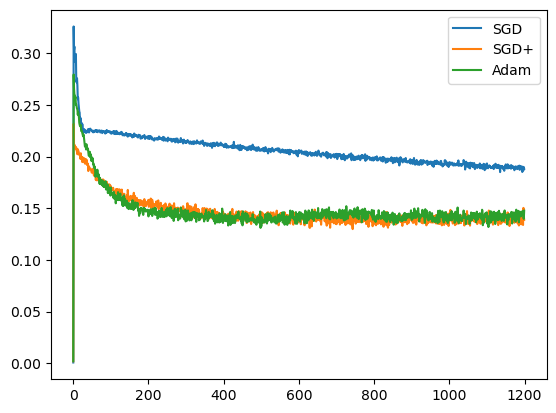

In [24]:
plt.plot(mp1.loss_running_record, label="SGD")
plt.plot(mp2.loss_running_record, label="SGD+")
# plt.plot(l3, label="SGD+")
plt.plot(mp3.loss_running_record, label="Adam")
plt.legend()
plt.show()

In [25]:
# def f1(*, a={}, flag=[True,]):
#     if flag[0]:
#         print("first time", a)
#         flag[0] = False
#         a['a'] = 1.0
#     else:
#         print("not first time", a)
#         a['a'] += 1.0

# f1()
# f1()
# f1()



all variables: {'xa', 'xw', 'xd', 'xb', 'xc'}


learnable params: ['ab', 'bc', 'cd', 'ac']


dependencies: {'xw': ['xa', 'xb', 'xc', 'xd']}


expressions dict: {'xw': 'ab*xa+bc*xb+cd*xc+ac*xd'}


var_to_var_param dict:  {'xw': {'xa': 'ab', 'xb': 'bc', 'xc': 'cd', 'xd': 'ac'}}


node to int labels:  {'xa': 0, 'xb': 1, 'xc': 2, 'xd': 3, 'xw': 4}


independent vars: ['xa', 'xd', 'xb', 'xc']


leads_to dictionary: {'xa': {'xw'}, 'xw': set(), 'xd': {'xw'}, 'xb': {'xw'}, 'xc': {'xw'}}
mu =  0.1 : SGD+ done


all variables: {'xa', 'xw', 'xd', 'xb', 'xc'}


learnable params: ['ab', 'bc', 'cd', 'ac']


dependencies: {'xw': ['xa', 'xb', 'xc', 'xd']}


expressions dict: {'xw': 'ab*xa+bc*xb+cd*xc+ac*xd'}


var_to_var_param dict:  {'xw': {'xa': 'ab', 'xb': 'bc', 'xc': 'cd', 'xd': 'ac'}}


node to int labels:  {'xa': 0, 'xb': 1, 'xc': 2, 'xd': 3, 'xw': 4}


independent vars: ['xa', 'xd', 'xb', 'xc']


leads_to dictionary: {'xa': {'xw'}, 'xw': set(), 'xd': {'xw'}, 'xb': {'xw'}, 'xc': {'xw'}}
mu =  

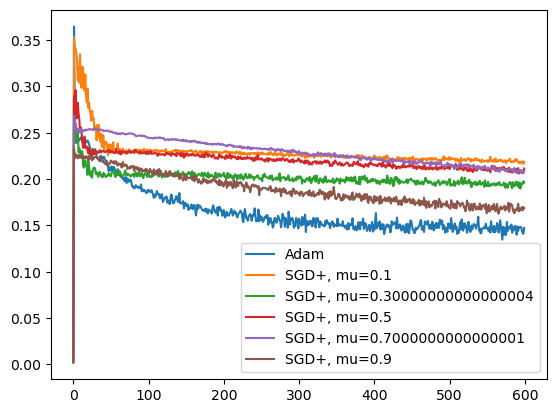

In [52]:
l = []
plt.figure()
plt.plot(mp3.loss_running_record, label="Adam")
for mu in np.linspace(0.1, 0.9, 5):
        mp2 = ModifiedPrimer(
                one_neuron_model = True,
                expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
                output_vars = ['xw'],
                dataset_size = 5000,
                learning_rate = 4e-3 / (1-mu),
                #               learning_rate = 5 * 1e-2,
                rate_mu = mu,
                training_iterations = 60000,
                batch_size = 8,
                display_loss_how_often = 100,
                debug = True,
        )
        mp2.parse_expressions()
        # mp.display_one_neuron_network() 
        training_data = mp2.gen_training_data()
        mp2.run_training_loop_one_neuron_model( training_data, algo="SGD+" )
        print("mu = ", mu, ": SGD+ done")
        plt.plot(mp2.loss_running_record, label="SGD+, mu="+str(mu))
plt.legend()
plt.show()
